# Interpolate `MeshArray` To Arbitrary Location

Each `MeshArray` contains elementary arrays that collectively form a global domain grid. Here we interpolate from the global grid to a set of arbitary locations. This is commonly done e.g. to compare climate models to sparse field observations.

In brief, the program finds a grid point quadrilateral (4 grid points) that encloses each chosen location. Computation is chuncked in subdomains (tiles) t o allow for parallelism. It outputs interpolation coefficients -- reusing those is easy and fast.

## Initialize Framework

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid
3. download the grid if needed


In [1]:
using MeshArrays, MITgcmTools, Plots

pth="../inputs/GRID_LLC90/"
γ=GridSpec("LatLonCap",pth)
Γ=GridLoad(γ)

http="https://github.com/gaelforget/GRID_LLC90"
!isdir(pth) ? run(`git clone $http $pth`) : nothing;

## Interpolation Code

- find nearest neighbor (`MeshArray` & `set`)
- define subdomain tiles (`MeshArray` -> `tiles`)
- exchange and start loop (`tile` & `subset`)
    - local stereographic projection
    - define array of quadrilaterals
    - find enclosing quadrilaterals
    - compute interpolation coefficients

### Find Nearest Neighbor

In [2]:
lon=collect(0.1:0.5:2.1); lat=collect(0.1:0.5:2.1);
(f,i,j,c)=knn(Γ["XC"],Γ["YC"],lon,lat)
[write(Γ["XC"])[c] write(Γ["YC"])[c]]

5×2 Array{Float64,2}:
 0.5  0.199365
 0.5  0.602104
 1.5  1.01667 
 1.5  1.4512  
 2.5  1.91446 

### Define Subdomain Tiles

_(as done in `InterpolationFactors`)_

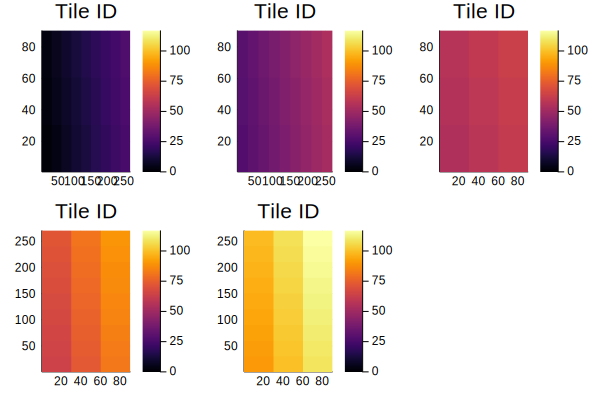

In [3]:
ni=30; nj=30;
τ=Tiles(γ,ni,nj)

tiles=MeshArray(γ,Int);
[tiles[τ[i]["face"]][τ[i]["i"],τ[i]["j"]].=i for i in 1:length(τ)];

using Plots
include(joinpath(dirname(pathof(MeshArrays)),"../examples/Plots.jl"))
heatmap(tiles,title="Tile ID",clims=(0,length(τ)))

### Example Setup

Hereafter we depict the interpolation problem setup:

1. in geographic coordinates. 
2. in the local stereographic coordinates used for interpolation.

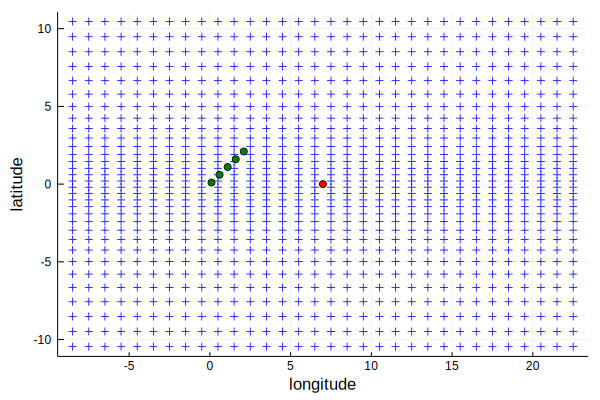

In [4]:
XCtiles=Tiles(τ,exchange(Γ["XC"]))
YCtiles=Tiles(τ,exchange(Γ["YC"]))

iiTile=17; iiFace=τ[iiTile]["face"]

ii0=minimum(τ[iiTile]["i"])+Int(ni/2); jj0=minimum(τ[iiTile]["j"])+Int(nj/2)
XC0=Γ["XG"].f[iiFace][ii0,jj0]; YC0=Γ["YG"].f[iiFace][ii0,jj0]

scatter(XCtiles[iiTile],YCtiles[iiTile],marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red); scatter!([lon],[lat],c=:green)

### Projection, Quadrilaterals, & Coefficients

_(as done in `InterpolationFactors`)_

In [5]:
#Local Stereographic Projection
(x_grid,y_grid)=StereographicProjection(XC0,YC0,XCtiles[iiTile],YCtiles[iiTile])
(x_trgt,y_trgt)=StereographicProjection(XC0,YC0,lon,lat)
~isa(x_trgt,Array) ? x_trgt=[x_trgt] : nothing
~isa(y_trgt,Array) ? y_trgt=[y_trgt] : nothing

#Identify Enclosing Quadrilaterals
(x_quad,y_quad,i_quad,j_quad)=QuadArrays(x_grid,y_grid)
angsum=PolygonAngle(x_quad,y_quad,x_trgt,y_trgt)
ii=findall(angsum.>180.)
ii=[ii[j].I[1] for j in 1:length(ii)]

#Interpolation Coefficients
px=x_quad[ii[1],:]'; py=y_quad[ii[1],:]'
ox=[x_trgt[1]]; oy=[y_trgt[1]]
ow=QuadCoeffs(px,py,ox,oy);

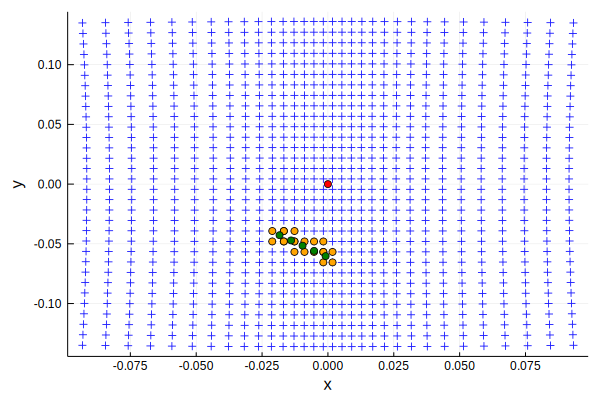

In [6]:
scatter(x_grid,y_grid,marker=:+,c=:blue,leg=false,xlabel="x",ylabel="y")
scatter!([0.],[0.],c=:red); scatter!(x_quad[ii,:],y_quad[ii,:],c=:orange)
scatter!(x_trgt,y_trgt,c=:green)

### Putting It All Together

Here we just call `InterpolationFactors`. We then interpolate longitude and latitude using the pre-computed coefficients and compare with initial `XC,YC` as a verification.

In [7]:
(f,i,j,w)=InterpolationFactors(Γ,lon,lat)

lon_i=similar(lon)
lat_i=similar(lat)
for jj=1:length(lon)
    x=[Γ["XC"][f[jj]][i[jj,ii],j[jj,ii]] for ii=1:4]
    y=[Γ["YC"][f[jj]][i[jj,ii],j[jj,ii]] for ii=1:4]
    lon_i[jj]=sum(w[jj,:].*x)
    lat_i[jj]=sum(w[jj,:].*y)
end

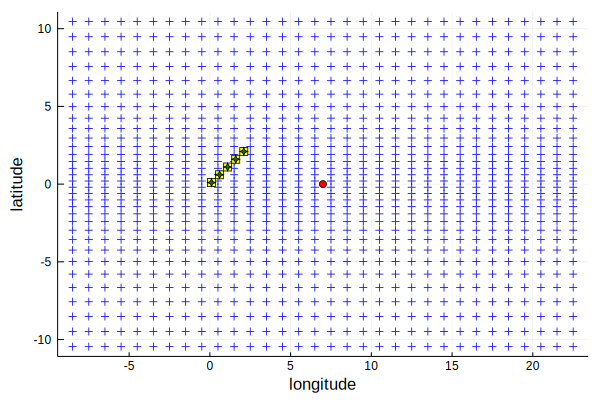

In [8]:
scatter(XCtiles[iiTile],YCtiles[iiTile],marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red); scatter!(lon_i,lat_i,c=:yellow,marker=:square)
scatter!(lon,lat,c=:green,marker=:star4)

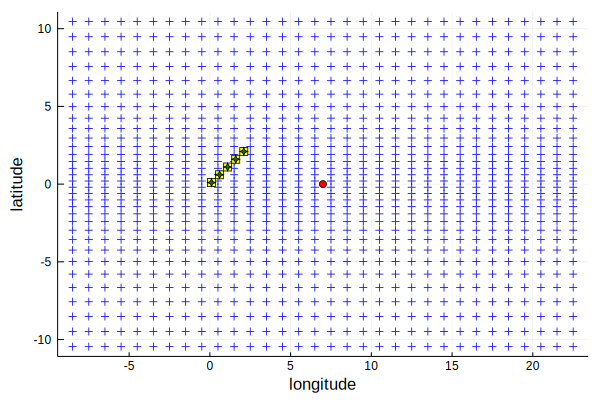

In [9]:
#or equivalently:

lon_i=similar(lon)
lat_i=similar(lat)
for jj=1:length(lon)
    x=[XCtiles[iiTile][i_quad[ii[jj],i]+1,j_quad[ii[jj],i]+1] for i=1:4]
    y=[YCtiles[iiTile][i_quad[ii[jj],i]+1,j_quad[ii[jj],i]+1] for i=1:4]
    lon_i[jj]=sum(x.*w[jj,:])
    lat_i[jj]=sum(y.*w[jj,:])
end

scatter(XCtiles[iiTile],YCtiles[iiTile],marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red); scatter!(lon_i,lat_i,c=:yellow,marker=:square)
scatter!(lon,lat,c=:green,marker=:star4)